In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import sys, os
os.environ["THEANO_FLAGS"] = "mode=FAST_RUN, device=cuda"

sys.path.append("../../../../git/gempy")
import gempy as gp

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm_notebook
from copy import copy, deepcopy
from gempy.assets import topology as tp
import logging

from gempy.assets import topology as tp
import gempy.assets.topology_post as tpost
import networkx as nx
from importlib import reload
reload(tp)
reload(tpost)
import ipywidgets as widgets
import matplotlib.colors as mcolors

Can not use cuDNN on context None: cannot compile with cuDNN. We got this error:
b'/tmp/try_flags_qrn68dub.c:4:10: fatal error: cudnn.h: No such file or directory\n #include <cudnn.h>\n          ^~~~~~~~~\ncompilation terminated.\n'
Mapped name None to device cuda: GeForce RTX 2070 (0000:01:00.0)


Active grids: ['regular']
Fault colors changed. If you do not like this behavior, set change_color to False.
Fault colors changed. If you do not like this behavior, set change_color to False.


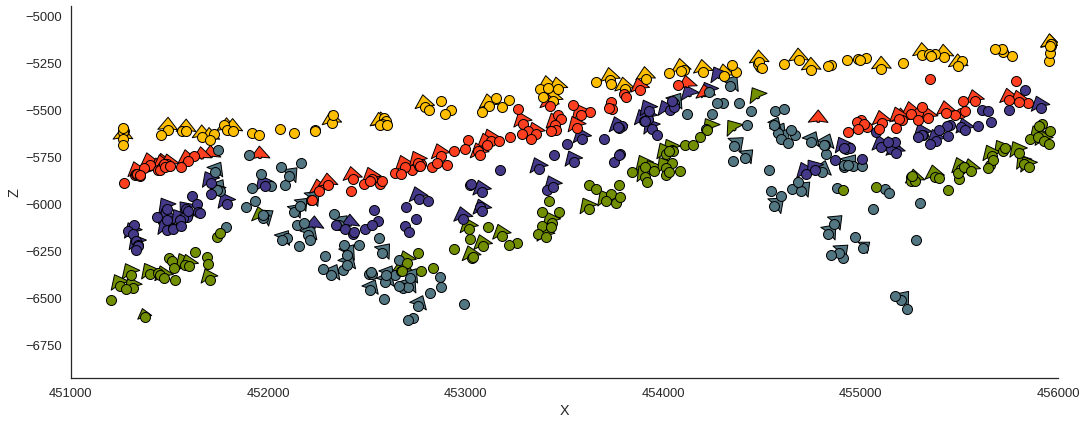

In [3]:
from create_geomodel_gullfaks import create_geomodel
geo_model = create_geomodel()
gp.plot.plot_data(geo_model)

In [4]:
cmap_gp = mcolors.ListedColormap(list(geo_model.surfaces.df['color']))

In [5]:
gp.set_interpolation_data(
    geo_model, 
    output='geology', 
    compile_theano=True, 
    theano_optimizer='fast_run', # fast_compile, fast_run
    dtype="float64",  # for model stability
    verbose=[]
)

Compiling theano function...
Level of Optimization:  fast_run
Device:  cuda
Precision:  float64
Number of faults:  2
Compilation Done!


### Shared variables

#### Kriging range

#### Sigmoid slope

#### Sigmoid Outside

#### Compute model

In [6]:
gp.compute_model(geo_model)
from copy import deepcopy
surface_points_init = deepcopy(geo_model.surface_points.df)
orientations_init = deepcopy(geo_model.orientations.df)

#### Visualize model

#### Compute Topology

In [7]:
from gempy.assets import topology as tp
reload(tp)
reload(tpost)
topo_init = tp.compute_topology(
    geo_model, 
    voxel_threshold=1
)  #, direction="Y", cell_number=15)
edges_init, centroids_init = tp.clean_unconformity_topology(
    geo_model, 
    1, 
    topo_init[0], 
    topo_init[1]
)

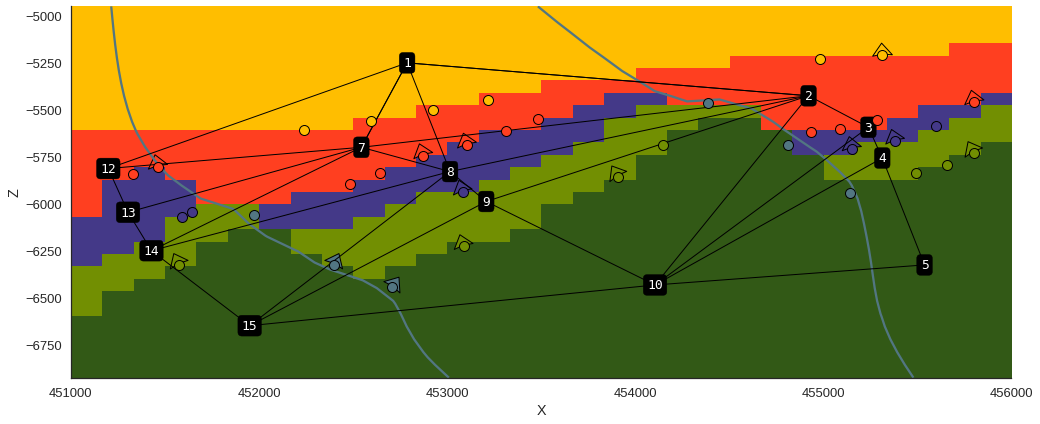

In [8]:
gp.plot.plot_section(geo_model, 15)
gp.plot.plot_topology(geo_model, edges_init, centroids_init)

In [9]:
from gempy.utils import stochastic_surface as ss
reload(ss)
stochastic_model = ss.StochasticModel(geo_model)

#### 3-D Visualization

# Stochastic model using ABCsampler

In [10]:
import scipy.stats

In [205]:
groups = geo_model.orientations.df.group.unique().astype(str)

reload(ss)
stochastic_model = ss._StochasticModel(geo_model)
zfactor = 0.004
xfactor = 0.0001
print("Uncertainty parametrization\n")
for group in groups:
    filter_ = geo_model.surface_points.df.group == group
    average_z = abs(geo_model.surface_points.df[filter_].Z.mean())
    average_y = abs(geo_model.surface_points.df[filter_].Y.mean())
    average_x = abs(geo_model.surface_points.df[filter_].X.mean())
    if "fault" in group:
        stdev_x = average_x * xfactor
        dist = scipy.stats.norm(loc=0, scale=stdev_x)
        stochastic_model.prior_surface_single(group, dist, column="X", grouping="group")
        print(f"{group.ljust(15)}σ = {average_x * xfactor:.01f} X")
    else:
        stdev_z = average_z * zfactor
        dist = scipy.stats.norm(loc=0, scale=stdev_z)
        stochastic_model.prior_surface_single(group, dist, column="Z", grouping="group")
        print(f"{group.ljust(15)}σ = {average_z * zfactor:.01f} Z")

Uncertainty parametrization

BCU            σ = 107.9 Z
fault3         σ = 43.5 X
fault4         σ = 44.8 X
tarbert A      σ = 62.0 Z
tarbert B      σ = 139.9 Z
tarbert C      σ = 23.9 Z
etive A        σ = 49.3 Z
etive B        σ = 8.1 Z
etive C        σ = 0.4 Z
ness A         σ = 52.3 Z
ness B         σ = 35.5 Z
ness C         σ = 126.1 Z


NameError: name 'posteriors' is not defined

In [29]:
simulate_settings = dict(
    compute_topology=True,
    record_lithblock=True,
    record_blockmatrix=False,
    record_surfaces=False,
    record_topology=True,
    clean_topology=1
)


def store(smod, settings):
    if len(smod.surfpts_samples) == 0:
        return
    smod.storage["surfpts"].append(smod.surfpts_samples[-1])
    smod.storage["orients"].append(smod.orients_samples[-1])
    if settings.get("record_lithblock"):
        smod.storage["lith_block"].append(
            np.round(smod.geo_model.solutions.lith_block)
        )
    if settings.get("record_blockmatrix"):
        smod.storage["block_matrix"].append(
            smod.geo_model.solutions.block_matrix
        )
    if settings.get("record_surfaces"):
        smod.storage["vertices"].append(
            smod.geo_model.solutions.vertices
        )
        smod.storage["simplices"].append(
            smod.geo_model.solutions.edges
        )
    if settings.get("record_topology"):
        smod.storage["topo_edges"].append(
            smod.geo_model.solutions.topo_edges
        )
        smod.storage["topo_centroids"].append(
            smod.geo_model.solutions.topo_centroids
        )
    return


def simulator(
        samples, 
        smod=stochastic_model, 
        settings=simulate_settings
    ):
    # put samples into their right places
    smod.sample(samples)
    smod.modify()
    
    # compute geomodel
    sol = gp.compute_model(
        smod.geo_model, 
        compute_mesh=settings.get("record_surfaces")
    )
    # compute topology
    edges, centroids = tp.compute_topology(
        smod.geo_model, 
        voxel_threshold=1)

    if settings.get("clean_topology"):
        edges, centroids = tp.clean_unconformity_topology(
            smod.geo_model, 
            settings.get("clean_topology"), 
            edges, 
            centroids
        )
    
    smod.geo_model.solutions.topo_edges = edges
    smod.geo_model.solutions.topo_centroids = centroids
    store(smod, settings)
    return edges


def summary(edges:set, observed:set) -> float:
    return tp.jaccard_index(edges, observed)


def distance(value:float) -> float:
    return 1. - value

In [30]:
sys.path.append("../../../abcsmc/")
import abcsamplers

In [31]:
reload(abcsamplers)
model = abcsamplers.ABCModel(priors, simulator, summary, distance)
rej = abcsamplers.REJ(model, edges_init)
rej.sample(10, threshold=0.05)

100%|██████████| 10/10 [00:09<00:00,  1.10it/s]


In [34]:
stochastic_model.surfpts_samples[-1]

,i,col,val
0,0,Z,-2.26591
1,1,Z,-2.26591
2,2,Z,-2.26591
3,3,Z,-2.26591
4,4,Z,-2.26591
...,...,...,...
505,301,Z,22.17965
506,302,Z,22.17965
507,303,Z,22.17965
508,304,Z,22.17965


In [14]:
rej.acceptance_rates[0]

1.0

In [65]:
stochastic_model.storage.keys()

dict_keys(['surfpts', 'orients', 'lith_block', 'block_matrix', 'vertices', 'simplices', 'topo_graphs', 'topo_edges', 'topo_centroids'])

In [66]:
len(stochastic_model.storage.get("lith_block"))

1884

In [67]:
def count_unique_topologies(topologies):
    unique_topologies = [topologies[0]]
    unique_topologies_count = [0]
    unique_topologies_idx = np.zeros_like(topologies)
    for n, edges in enumerate(topologies):
        skip = False
        for m, edges_unique in enumerate(unique_topologies):
            if edges == edges_unique:  # if len(edges_unique ^ edges) == 0:
                unique_topologies_count[m] += 1
                unique_topologies_idx[n] = m
                skip = True
                break
        if not skip:
            unique_topologies.append(edges)
            unique_topologies_count.append(1)
            unique_topologies_idx[n] = len(unique_topologies) - 1
            
    return np.array(unique_topologies), np.array(unique_topologies_count), unique_topologies_idx

In [68]:
a, b, c = count_unique_topologies(stochastic_model.storage.get("topo_edges"))

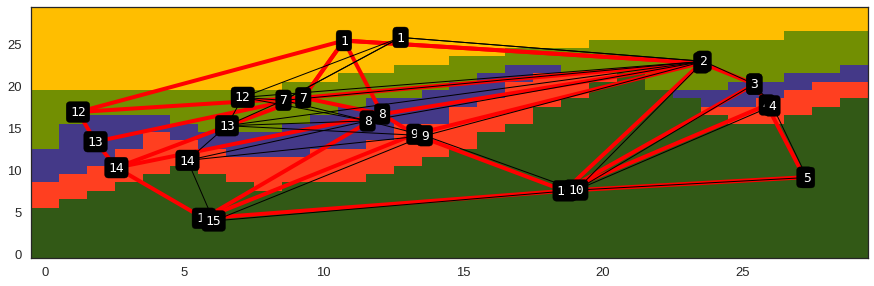

In [73]:
%matplotlib inline
@widgets.interact(
    Iteration=widgets.IntSlider(min=0, max=len(stochastic_model.storage.get("lith_block"))-1, value=1000),
    Slice=widgets.IntSlider(min=0, max=29, value=15)
)
def potato(Iteration, Slice):
    i = Iteration
    fig, ax = plt.subplots(figsize=(15,10))
    ax.imshow(
        stochastic_model.storage.get("lith_block")[i].reshape(geo_model.grid.regular_grid.resolution)[:, Slice, :].T,
        origin="lower", aspect=0.3,
        cmap=cmap_gp
    )
    edges, ctr = stochastic_model.storage.get("topo_edges")[i], stochastic_model.storage.get("topo_centroids")[i]
    gp.plot.plot_topology(geo_model, edges_init, centroids_init, edge_kwargs=dict(color="red", linewidth=4), scale=False)
    gp.plot.plot_topology(geo_model, edges, ctr, scale=False)
    

# DEP

In [7]:
import gempy.utils.stochastic_surface as ss
groups = geo_model.orientations.df.group.unique().astype(str)
print("Stochastic groups:\n")
print(groups)

Stochastic groups:

['BCU' 'fault3' 'fault4' 'tarbert A' 'tarbert B' 'tarbert C' 'ness A'
 'ness B' 'ness C' 'etive A' 'etive B' 'etive C']


In [41]:
# factor = 0.01
# factor = 0.0075
# factor = 0.005
zfactor = 0.004
xfactor = 0.0001
stochastic_surfaces = []
print("Uncertainty parametrization\n")
for group in groups:
    filter_ = geo_model.surface_points.df.group == group
    average_z = abs(geo_model.surface_points.df[filter_].Z.mean())
    average_x = abs(geo_model.surface_points.df[filter_].X.mean())
    
    stochsurf = ss.StochasticSurfaceScipy(geo_model, group, grouping="group")
    if "fault" in group:
        stdev_x = average_x * xfactor 
#         stochsurf.parametrize_surfpts_individual(stdev_x, direction="X")
        stochsurf.parametrize_surfpts_single(stdev_x, direction="X")
        print(f"{group.ljust(15)}σ = {average_x * xfactor:.01f} X")
    else:
        stdev_z = average_z * zfactor
        stochsurf.parametrize_surfpts_individual(stdev_z)
#         stochsurf.parametrize_surfpts_single(stdev_z)
        print(f"{group.ljust(15)}σ = {average_z * zfactor:.01f} Z")
    
    stochastic_surfaces.append(stochsurf)

Uncertainty parametrization

BCU            σ = 21.6 Z
fault3         σ = 45.5 X
fault4         σ = 45.2 X
etive A        σ = 25.5 Z
etive B        σ = 24.0 Z
etive C        σ = 23.1 Z
ness A         σ = 24.3 Z
ness B         σ = 23.4 Z
ness C         σ = 22.6 Z
tarbert A      σ = 23.3 Z
tarbert B      σ = 22.7 Z
tarbert C      σ = 22.1 Z


In [42]:
stochastic_model = ss.StochasticModel(geo_model, stochastic_surfaces)

In [43]:
reload(ss)
def simulate(
    smod:ss.StochasticModel, 
    geo_model,
    compute_topology:bool=False,
    record_lithblock:bool=False,
    record_blockmatrix:bool=False,
    record_surfaces:bool=False, 
    record_topology:bool=False,
    clean_topology:int=None
    ) -> None:
    
    smod.sample()  # draw samples from priors
    smod.modify()  # modify geomodel data with samples
    # compute geomodel
    sol = gp.compute_model(geo_model, compute_mesh=record_surfaces)
    # compute topology
    if compute_topology:
        edges, centroids = tp.compute_topology(geo_model, voxel_threshold=1)
        if clean_topology:
            edges, centroids = tp.clean_unconformity_topology(geo_model, clean_topology, edges, centroids)
            
    # storage
    # by default it only stores input data samples
    smod.storage["surfpts"].append(smod.surfpts_samples[-1])
    smod.storage["orients"].append(smod.orients_samples[-1])
    if record_lithblock:
        smod.storage["lith_block"].append(np.round(sol.lith_block))
    if record_blockmatrix:
        smod.storage["block_matrix"].append(sol.block_matrix)
    if record_surfaces:
        smod.storage["vertices"].append(sol.vertices)
        smod.storage["simplices"].append(sol.edges)
    if record_topology:
        smod.storage["topo_edges"].append(edges)
        smod.storage["topo_centroids"].append(centroids)

In [15]:
simulate_settings = dict(
    compute_topology=True,
    record_lithblock=True,
    record_blockmatrix=False,
    record_surfaces=True,
    record_topology=True,
    clean_topology=1
)

In [44]:
for i in tqdm_notebook(range(400)):
    simulate(stochastic_model, geo_model, **simulate_settings)

KeyboardInterrupt: 

In [45]:
from gempy.bayesian import posterior_analysis_DEP as pa
lith_blocks = np.array(stochastic_model.storage["lith_block"]).round().astype(int)
# lith_blocks = np.array(stochastic_model.storage["block_matrix"])[:, -1, : , :].round().astype(int)
# lith_prob = pa.calculate_probability_lithology(lith_blocks[:, 0 , :])
lith_prob = pa.calculate_probability_lithology(lith_blocks)
ie = pa.calculate_information_entropy(lith_prob)
ie = ie.reshape(geo_model.grid.regular_grid.resolution)

0.12853597484555263


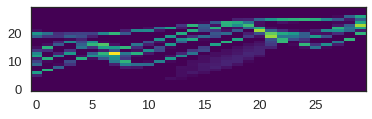

In [46]:
%matplotlib inline
plt.imshow(
    ie[:, 5, :].T, 
    origin="lower",
    cmap="viridis", 
    aspect=0.25,
    interpolation="nearest"
)
print(np.average(ie))

Text(0.5, 1.0, 'Nodes')

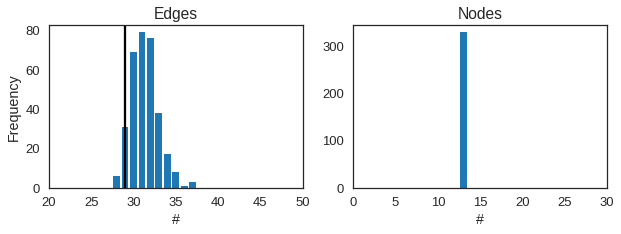

In [47]:
n_edges_max = 50
edge_counter = np.zeros(n_edges_max)
for edges in stochastic_model.storage["topo_edges"]:
    edge_counter[len(edges)] += 1
    
node_counter = np.zeros(30)
for edges in stochastic_model.storage["topo_edges"]:
    node_counter[len(np.unique(list(edges)))] += 1

fig, axes = plt.subplots(ncols=2, figsize=(10,3))

ax = axes[0]
ax.bar(range(n_edges_max), edge_counter)
ax.set_xlim(20, n_edges_max)
ax.set_xlabel("#")
ax.set_ylabel("Frequency")
ax.set_title("Edges")
ax.axvline(len(edges_init), color="black")

ax = axes[1]
ax.bar(range(30), node_counter)
ax.set_xlim(0, 30)
ax.set_xlabel("#")
# ax.set_ylabel("Frequency")
ax.set_title("Nodes")

In [48]:
%matplotlib inline
@widgets.interact(
    Iteration=widgets.IntSlider(min=0, max=len(stochastic_model.storage.get("lith_block"))-1),
    Slice=widgets.IntSlider(min=0, max=29, value=15)
)
def potato(Iteration, Slice):
    i = Iteration
    fig, ax = plt.subplots(figsize=(15,10))
    ax.imshow(
        stochastic_model.storage.get("lith_block")[i].reshape(geo_model.grid.regular_grid.resolution)[:, Slice, :].T,
        origin="lower", aspect=0.3,
        cmap=cmap_gp
    )
    edges, ctr = stochastic_model.storage.get("topo_edges")[i], stochastic_model.storage.get("topo_centroids")[i]
    gp.plot.plot_topology(geo_model, edges_init, centroids_init, edge_kwargs=dict(color="red", linewidth=4), scale=False)
    gp.plot.plot_topology(geo_model, edges, ctr, scale=False)
    

interactive(children=(IntSlider(value=0, description='Iteration', max=327), IntSlider(value=15, description='S…

In [49]:
def calc_volumes(lith_blocks):
    volumes = {lith_id:[] for lith_id in np.unique(lith_blocks[0])}
    for lith_id in np.unique(lith_blocks[0]):
        volumes[lith_id].append(
            np.count_nonzero(lith_blocks == lith_id, axis=1)
        )
    return volumes
        

lith_blocks = np.array(stochastic_model.storage["lith_block"]).astype(int)
volumes = calc_volumes(lith_blocks)

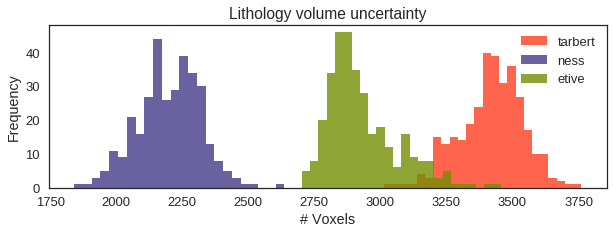

In [50]:
fig, ax = plt.subplots(figsize=(10,3))

for lith_id, vols in volumes.items():
    if lith_id == 0 or lith_id == 7 or lith_id == 3 or lith_id == 1:
        continue
    color = geo_model.surfaces.df.color[geo_model.surfaces.df.id == lith_id].values[0]
    label = geo_model.surfaces.df.surface[geo_model.surfaces.df.id == lith_id].values[0]
    ax.hist(vols, label=label, bins=24, alpha=0.8, color=color)
ax.legend()
ax.set_title("Lithology volume uncertainty")
ax.set_xlabel("# Voxels")
ax.set_ylabel("Frequency");

In [51]:
from typing import List, Set, Tuple

In [52]:
def count_unique_topologies(topologies:List[Set[Tuple[int, int]]]):
    unique_topologies = [topologies[0]]
    unique_topologies_count = [0]
    unique_topologies_idx = np.zeros_like(topologies)
    for n, edges in enumerate(topologies):
        skip = False
        for m, edges_unique in enumerate(unique_topologies):
            if edges == edges_unique:  # if len(edges_unique ^ edges) == 0:
                unique_topologies_count[m] += 1
                unique_topologies_idx[n] = i
                skip = True
                break
        if not skip:
            unique_topologies.append(edges)
            unique_topologies_count.append(1)
            unique_topologies_idx[n] = len(unique_topologies) - 1
            
    return np.array(unique_topologies), np.array(unique_topologies_count), unique_topologies_idx

In [53]:
unique_edges, unique_edges_count, unique_edges_idx = count_unique_topologies(stochastic_model.storage["topo_edges"])

<BarContainer object of 40 artists>

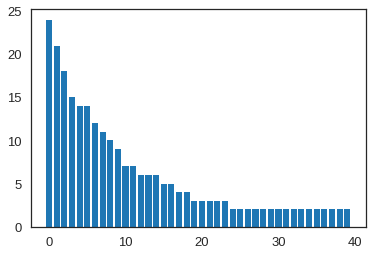

In [62]:
n = 40
plt.bar(np.arange(n), np.sort(unique_edges_count)[::-1][:n])

(0, 1)

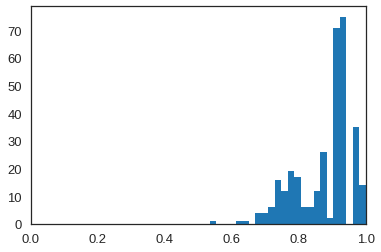

In [64]:
jaccard = [tp.jaccard_index(edges_init, e) for e in stochastic_model.storage["topo_edges"]]
plt.hist(jaccard, bins=24);
plt.xlim(0, 1)

In [ ]:
def abc_rej(n_iter, epsilon, obs_thickness):
    """ABC-REJ algorithm from Sadegh and Vrught (2014)."""
    posterior_l1 = []
    posterior_l2 = []
    obs_thickness = np.array(obs_thickness)

    for i in tqdm.tqdm(range(n_iter)):
        distance = epsilon + 1
        while distance > epsilon:
            l1 = layer_1.rvs()
            l2 = layer_2.rvs()
            thickness = l1 - l2
            distance = np.mean(np.sqrt(np.square(obs_thickness - thickness)))
        posterior_l1.append(l1)
        posterior_l2.append(l2)
        
    return np.stack((posterior_l1, posterior_l2), axis=1)

# DEP

In [175]:
from scipy.stats import multivariate_normal, invwishart
import seaborn as sns

In [77]:
@widgets.interact(
    a = widgets.FloatSlider(min=1,max=10,step=0.5),
    b = widgets.FloatSlider(min=1,max=10,step=0.5),
    c = widgets.FloatSlider(min=1,max=10,step=0.5),
    d = widgets.FloatSlider(min=1,max=10,step=0.5)
)
def test_cov(a, b, c, d):
    samples = multivariate_normal(mean=[0, 0], cov=[[a, c],[d, b]]).rvs(500)
    plt.scatter(samples[:,0], samples[:, 1], s=5, alpha=0.5)
#     axes = sns.jointplot(x=samples[:, 0], y=samples[:, 1])
    ax = plt.gca()
    ax.set_ylim(-10, 10)
    ax.set_xlim(-10, 10)
#     return axes

interactive(children=(FloatSlider(value=1.0, description='a', max=10.0, min=1.0, step=0.5), FloatSlider(value=…

In [131]:
data = geo_model.surface_points.df[geo_model.surface_points.df.group=="etive A"]

In [ ]:
invwishart.rvs(22, np.ones(22))

In [344]:
@widgets.interact(
    
)
def p():
    n_points = len(data)
    sample = multivariate_normal(mean=np.zeros(22), cov=invwishart.rvs(df=60, scale=10*np.ones(22))).rvs()
    sample2= np.random.randn(22)
    fig, ax = plt.subplots()
    ax.plot(np.arange(n_points), np.zeros(n_points) + sample, label="multivariate")
    ax.plot(np.arange(n_points), np.zeros(n_points) + sample2, color="grey", label="indie")
    ax.axhline(0, color="black", alpha=0.2, linewidth=1)
    ax.set_ylim(-5, 5)
    ax.legend()

interactive(children=(Output(),), _dom_classes=('widget-interact',))

In [371]:
@widgets.interact(
    s=widgets.FloatSlider(value=1, min=0.1, max=2)
)
def p(s):
    plt.plot(np.linspace(0, 5, num=1000), lognorm.pdf(s, np.linspace(0, 5, num=1000)))

interactive(children=(FloatSlider(value=1.0, description='s', max=2.0, min=0.1), Output()), _dom_classes=('wid…

In [345]:
from scipy.stats import lognorm

#### Filter group points by fb extent

In [ ]:
res = geo_model.grid.regular_grid.resolution
fb2 = geo_model.solutions.block_matrix[0] - (0 + 1)
fb2 = ~fb2.astype(bool)
fb1 = geo_model.solutions.block_matrix[1] - (1 + 1)
fb1 = fb1.astype(bool)

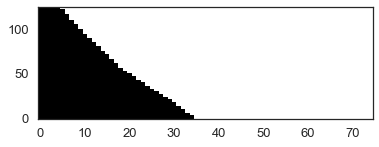

In [9]:
im = plt.imshow(fb1.reshape(*res)[:, 45, :].T, origin="lower", aspect=0.2)

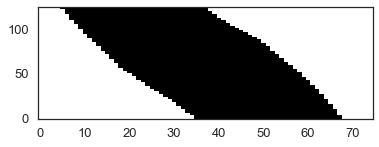

In [10]:
fb12 = np.logical_and(~fb1, ~fb2)
im = plt.imshow(fb12.reshape(*res)[:, 45, :].T, origin="lower", aspect=0.2)

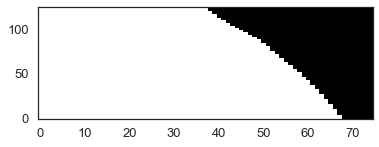

In [11]:
im = plt.imshow(fb2.reshape(*res)[:, 45, :].T, origin="lower", aspect=0.2)

In [12]:
from scipy.spatial.distance import cdist

In [15]:
group_suffix = "A"
surface_points_remove = []

def a(geo_model, fb, i):
    grid_inside = geo_model.grid.get_grid("regular")[fb[0, :]]
    grid_outside = geo_model.grid.get_grid("regular")[~fb[0, :]]
    data = geo_model.surface_points.df.iloc[i][["X", "Y", "Z"]].values
    distance_inside = np.min(cdist(data, grid_inside), axis=1)
    distance_outside = np.min(cdist(data, grid_outside), axis=1)
    outside_filter = distance_inside > distance_outside
    return i[outside_filter]
    

for group_suffix, fb in zip(["A", "B", "C"], [fb1, fb12, fb2]):
    print(f"Fault block {group_suffix}")
    for group, i in geo_model.surface_points.df.groupby("group").groups.items():
        if not group.endswith(group_suffix):
            continue
            
        df_filter = a(geo_model, fb, i)        
        
        print(f"{group}: Found {len(df_filter)} surface points that are outside of fault block {group_suffix}")
        if len(df_filter) == 0:
            continue
        for p in df_filter:
            surface_points_remove.append(p)
        
    print("\n")
        
    

Fault block A
etive A: Found 10 surface points that are outside of fault block A
ness A: Found 3 surface points that are outside of fault block A
tarbert A: Found 0 surface points that are outside of fault block A


Fault block B
etive B: Found 3 surface points that are outside of fault block B
ness B: Found 4 surface points that are outside of fault block B
tarbert B: Found 3 surface points that are outside of fault block B


Fault block C
etive C: Found 1 surface points that are outside of fault block C
ness C: Found 1 surface points that are outside of fault block C
tarbert C: Found 0 surface points that are outside of fault block C




In [29]:
import pyvista as pv

p = pv.Plotter(notebook=False)
for group, i in geo_model.orientations.df.groupby("surface").groups.items():
    if group == "basement":
        continue
    pts = geo_model.orientations.df.loc[i][["X", "Y", "Z"]].values
    nrms = geo_model.orientations.df.loc[i][["G_x", "G_y", "G_z"]].values
    for pt, nrm in zip(pts, nrms):
        p.add_mesh(
            pv.Line(pointa=pt, pointb=pt + 250 * nrm)
        )
        
for group, i in geo_model.surface_points.df.groupby("surface").groups.items():
    pts = geo_model.surface_points.df.loc[i][["X", "Y", "Z"]].values
    if len(pts) == 0:
        continue
    p.add_mesh(
        pv.PolyData(pts), color=geo_model.surfaces.df.iloc[geo_model.surface_points.df.loc[i[0]].id].color
    )

p.show()

[(455878.30698867637, 6793463.014709425, -5221.31424945923),
 (453548.921875, 6783046.5, -5769.04345703125),
 (-0.17116793270762476, -0.013524568519392294, 0.9851490368766352)]

'#325916'